In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import requests
import json

In [11]:
headers = {
    "token": "QBzqRxBKUHUOpoLVBhEeXsYmSsRciZwk"
}

### Getting the bounding box:

In [3]:
la_bounds_gdf = gpd.read_file("../../Data/Inputs/Boundary_Shapefile/City_Boundaries.geojson")

ImportError: The 'read_file' function requires the 'pyogrio' or 'fiona' package, but neither is installed or imports correctly.
Importing pyogrio resulted in: No module named 'pyogrio'
Importing fiona resulted in: No module named 'fiona'

In [4]:
la_bounds_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

According to the doccumentation, the order for the bounding box limits must match:

    47.5204,-122.2047,47.6139,-122.1065

i.e. `S,W,N,E`. I can force this ordering:

In [5]:
la_bounding_box = [f"{str(la_bounds_gdf.total_bounds[i])}" for i in [1,0,-1,2]]

In [6]:
print(la_bounding_box)

['33.7046743723892', '-118.944703049253', '34.823304156602', '-117.646385981235']


I need to convert this list to a string seperated by commas. is extremely crude but will work for now:

In [8]:
la_extent_str = str(la_bounding_box).replace('[','').replace(']','').replace("'",'').replace(' ','')

In [9]:
print(la_extent_str)

33.7046743723892,-118.944703049253,34.823304156602,-117.646385981235


https://www.ncdc.noaa.gov/cdo-web/webservices/v2#stations

This bounding box can be used as an extent to select stations:

In [18]:
url = f"https://www.ncei.noaa.gov/cdo-web/api/v2/stations?extent={la_extent_str}&limit=1000"
response = requests.get(url,headers=headers)
print(response)
noaa_la_stations = response.json()

<Response [200]>


In [19]:
noaa_la_stations.keys()

dict_keys(['metadata', 'results'])

In [20]:
noaa_la_stations['metadata']

{'resultset': {'offset': 1, 'count': 494, 'limit': 1000}}

In [21]:
noaa_la_stations['results'][0]

{'elevation': 863.5,
 'mindate': '1931-01-01',
 'maxdate': '2013-12-01',
 'latitude': 34.4938,
 'name': 'ACTON ESCONDIDO CANYON, CA US',
 'datacoverage': 0.8986,
 'id': 'COOP:040014',
 'elevationUnit': 'METERS',
 'longitude': -118.2713}

In [26]:
noaa_stations_df = pd.DataFrame(noaa_la_stations['results'])

In [27]:
noaa_stations_df.head(3)

,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude
0,863.5,1931-01-01,2013-12-01,34.49380,"ACTON ESCONDIDO CANYON, CA US",0.8986,COOP:040014,METERS,-118.27130
1,721.5,1939-09-01,1992-10-30,34.31667,"ALISO CANYON FC 446, CA US",0.9711,COOP:040115,METERS,-118.55000
2,343.5,1931-01-01,2015-11-01,34.18211,"ALTADENA, CA US",0.9362,COOP:040144,METERS,-118.13827


### Converting to gdf:

In [29]:
noaa_stations_gdf = gpd.GeoDataFrame(
   noaa_stations_df, geometry=gpd.points_from_xy(noaa_stations_df['longitude'], noaa_stations_df['latitude']), crs="EPSG:4326"
)

In [32]:
noaa_stations_gdf.head(3)

,elevation,mindate,maxdate,latitude,name,datacoverage,id,elevationUnit,longitude,geometry
0,863.5,1931-01-01,2013-12-01,34.49380,"ACTON ESCONDIDO CANYON, CA US",0.8986,COOP:040014,METERS,-118.27130,POINT (-118.2713 34.4938)
1,721.5,1939-09-01,1992-10-30,34.31667,"ALISO CANYON FC 446, CA US",0.9711,COOP:040115,METERS,-118.55000,POINT (-118.55 34.31667)
2,343.5,1931-01-01,2015-11-01,34.18211,"ALTADENA, CA US",0.9362,COOP:040144,METERS,-118.13827,POINT (-118.13827 34.18211)


In [33]:
noaa_stations_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   elevation      494 non-null    float64 
 1   mindate        494 non-null    object  
 2   maxdate        494 non-null    object  
 3   latitude       494 non-null    float64 
 4   name           494 non-null    object  
 5   datacoverage   494 non-null    float64 
 6   id             494 non-null    object  
 7   elevationUnit  494 non-null    object  
 8   longitude      494 non-null    float64 
 9   geometry       494 non-null    geometry
dtypes: float64(4), geometry(1), object(5)
memory usage: 38.7+ KB


In [37]:
noaa_stations_gdf['mindate'] = pd.to_datetime(noaa_stations_gdf['mindate'])
noaa_stations_gdf['maxdate'] = pd.to_datetime(noaa_stations_gdf['maxdate'])

In [38]:
noaa_stations_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   elevation      494 non-null    float64       
 1   mindate        494 non-null    datetime64[ns]
 2   maxdate        494 non-null    datetime64[ns]
 3   latitude       494 non-null    float64       
 4   name           494 non-null    object        
 5   datacoverage   494 non-null    float64       
 6   id             494 non-null    object        
 7   elevationUnit  494 non-null    object        
 8   longitude      494 non-null    float64       
 9   geometry       494 non-null    geometry      
dtypes: datetime64[ns](2), float64(4), geometry(1), object(3)
memory usage: 38.7+ KB


In [39]:
pm_25 = gpd.read_file(r'../../Data/Outputs/recents_pm25.geojson')

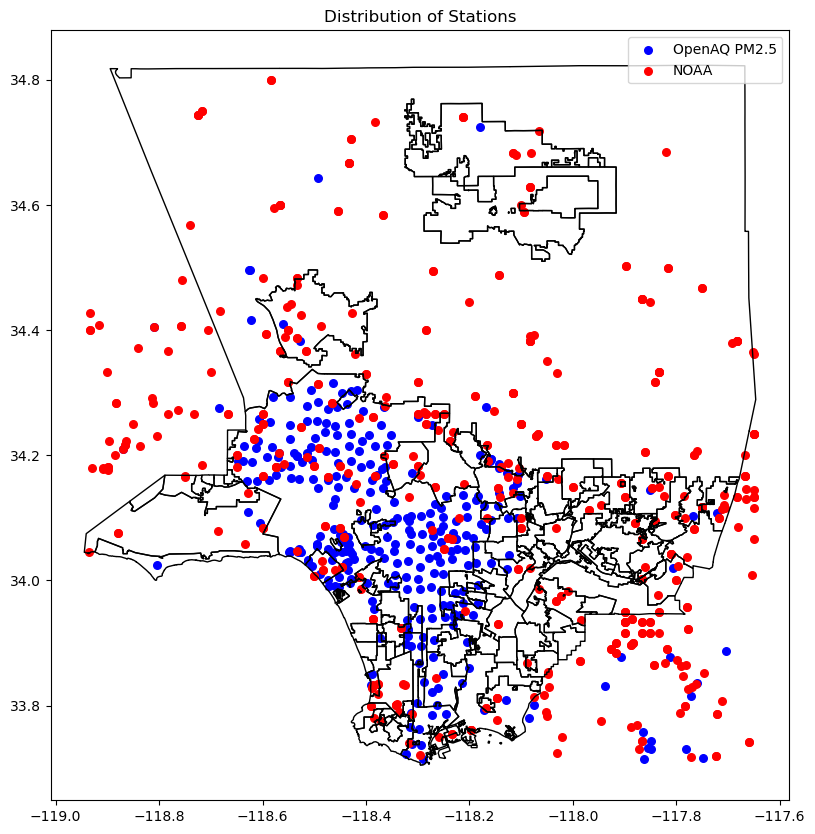

In [40]:
fig, ax = plt.subplots(figsize=(10, 10), label='Inline label');

pm_25.plot(ax=ax, color='blue', edgecolor='blue', markersize=30);
noaa_stations_gdf.plot(ax=ax, color='red', markersize=30);
la_bounds_gdf.plot(ax=ax, color='none', edgecolor='black');
ax.legend(['OpenAQ PM2.5','NOAA']);
plt.title('Distribution of Stations');

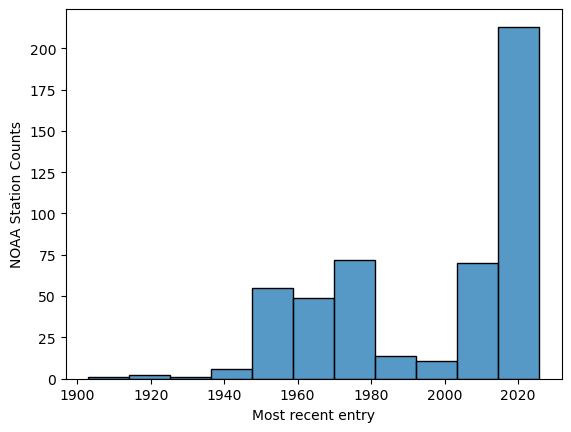

In [44]:
plt.plot(figsize=(8,2),dpi=200)
sns.histplot(data=noaa_stations_gdf, x='maxdate', bins=11);
plt.ylabel('NOAA Station Counts');
plt.xlabel('Most recent entry');

In [45]:
noaa_stations_gdf.to_file('../../Data/Outputs/noaa_stations_gdf.geojson', driver='GeoJSON')